## Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')
from estimadores import *

## Lectura de datos

In [2]:
vmac = pd.read_csv('variables_final.csv')
vmac = vmac.drop(['brent'], axis=1)
vmac['Fecha'] = pd.to_datetime(vmac['Fecha'], format='%d/%m/%Y')
vmac.set_index('Fecha', inplace=True)
variables_macro = vmac.drop(['INPC'], axis=1).columns
vmac['quincena'] = vmac.groupby(vmac.index.year).cumcount() + 1
vmac['INPC_desplazado'] = vmac['INPC'].shift(1)
vmac['INPC_transf'] = vmac['INPC'] - vmac['INPC_desplazado']
for rezago in [1, 2, 3, 4, 10, 11, 12, 13, 14, 22, 23, 24, 25, 26]:
    vmac['INPC_transf_rezago_' + str(rezago)] = vmac['INPC_transf'].shift(rezago)
for col in variables_macro:
    for rezago in [1, 2]:
        vmac[col + '_transf_rezago_' + str(rezago)] = vmac[col].diff().shift(rezago)
vmac = vmac.drop(variables_macro, axis=1)
vmac = vmac.loc['2001':]

## Conjuntos de prueba y entrenamiento

In [3]:
train = vmac.loc[:'2014']
test = vmac.loc['2015':]
test = test.drop(pd.to_datetime('2017-01-17'))
print("Train pct: {:.2f}%\nTest pct: {:.2f}%".format(train.shape[0] / (vmac.shape[0] - 1), 
                                                   test.shape[0] / (vmac.shape[0] - 1)))

Train pct: 0.83%
Test pct: 0.17%


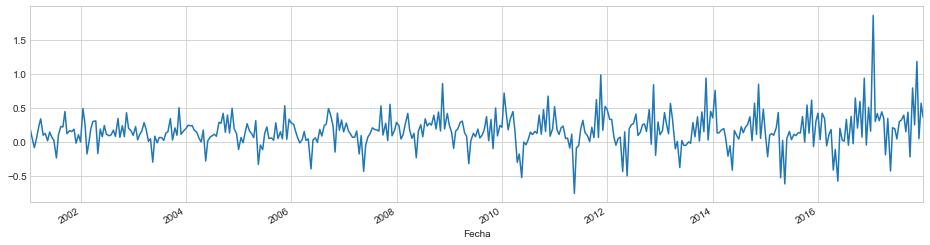

In [4]:
vmac.loc[:, 'INPC_transf'].plot(figsize=(16, 4));

## Modelos

In [5]:
X_train = train.drop(['INPC', 'INPC_desplazado', 'INPC_transf', 'quincena'], axis=1)
y_train = train['INPC_transf']
X_test = test.drop(['INPC', 'INPC_desplazado', 'INPC_transf', 'quincena'], axis=1)
y_test = test['INPC_transf']

In [6]:
from sklearn.metrics import mean_squared_error
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

cv = MySplits(n_splits=3, test_size = 24 * 3)

def evalua_modelo(model, imprime=True):
    train_rmse = np.sqrt(mean_squared_error(vmac.loc[y_train.index, 'INPC'],
                                           model.predict(X_train) +
                                           vmac.loc[y_train.index, 'INPC_desplazado']))
    val_err = []
    val_series = None
    for train_idx, test_idx in cv.split(X_train):
        mod = clone(model)
        mod.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])
        val_err.append(np.sqrt(mean_squared_error(vmac.loc[y_train[test_idx].index, 'INPC'],
                                              mod.predict(X_train.iloc[test_idx]) +
                                              vmac.loc[y_train[test_idx].index, 'INPC_desplazado'])))
        val_series = pd.concat([val_series, pd.Series(mod.predict(X_train.iloc[test_idx]),
                                                     index=X_train.iloc[test_idx].index)])
        
    cv_rmse = np.mean(val_err)
    val_series.sort_index(inplace=True)
    
    test_preds = [model.predict(X_test[:1])]
    mod = clone(model)
    for i in range(X_test.shape[0] - 1):
        X_train_aug = X_train.append(X_test[:i + 1])
        y_train_aug = y_train.append(y_test[:i + 1])
        mod.fit(X_train_aug, y_train_aug)
        test_preds.append(mod.predict(X_test[i + 1:i + 2]))
    test_preds = np.array(test_preds).ravel()
    test_rmse = np.sqrt(mean_squared_error(test_preds + vmac.loc[y_test.index, 'INPC_desplazado'], 
                                           vmac.loc[y_test.index, 'INPC']))
    
    if imprime:
        model_name = type(model.named_steps['estimator']).__name__
        print("{} train error: {:.4f}\n{} 5-fold CV error: {:.4f}\n{} test error: {:.4f}".
              format(model_name, train_rmse, model_name, cv_rmse, model_name, test_rmse))
        
        fig, ax = plt.subplots(nrows=2, figsize=(16, 6), gridspec_kw={'hspace': 0.5})
        
        
        ax[0].plot(val_series.index, y_train.loc[val_series.index], 'k-', label='real')
        ax[0].plot(val_series.index, val_series.values, 'r--', label='predicción')
        ax[0].legend(loc='upper left')
        ax[0].set_title('Validación')
        ax[0].set_xlim((val_series.index.min(), val_series.index.max()))
        
        ax[1].plot(y_test.index, y_test.values, 'k-', label='real')
        ax[1].plot(y_test.index, test_preds, 'r--', label='predicción')
        ax[1].legend(loc='upper left')        
        ax[1].set_title('Prueba')
        ax[1].set_xlim((y_test.index.min(), y_test.index.max()));
    else:
        return train_rmse, cv_rmse, test_rmse

## SVM Gaussian

SVR train error: 0.1376
SVR 5-fold CV error: 0.1546
SVR test error: 0.2082


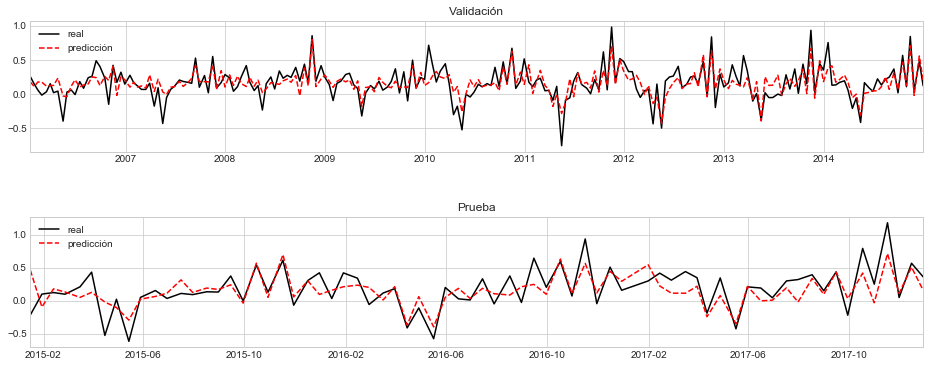

In [8]:
from sklearn.svm import SVR

svm = Pipeline([('selector', SelectorMacro(INPC_transf_rezago_1 =True,
                                           INPC_transf_rezago_2 =True,
                                           INPC_transf_rezago_3 =False,
                                           INPC_transf_rezago_4 =True,
                                           INPC_transf_rezago_10=False,
                                           INPC_transf_rezago_11=True,
                                           INPC_transf_rezago_12=True,
                                           INPC_transf_rezago_13=False,
                                           INPC_transf_rezago_14=False,
                                           INPC_transf_rezago_22=True,
                                           INPC_transf_rezago_23=False,
                                           INPC_transf_rezago_24=True,
                                           INPC_transf_rezago_25=True,
                                           INPC_transf_rezago_26=True,
                                           usd_transf_rezago_1      =False,
                                           usd_transf_rezago_2      =False,
                                           tiie_transf_rezago_1     =False,
                                           tiie_transf_rezago_2     =True,
                                           IPC_transf_rezago_1      =False,
                                           IPC_transf_rezago_2      =True,
                                           WTI_transf_rezago_1      =False,
                                           WTI_transf_rezago_2      =False,
                                           IGAE_transf_rezago_1     =False,
                                           IGAE_transf_rezago_2     =False,
                                           yield_usa_transf_rezago_1=False, 
                                           yield_usa_transf_rezago_2=False,
                                           yield_mex_transf_rezago_1=False, 
                                           yield_mex_transf_rezago_2=False)),
                ('scaler', MinMaxScaler()),
                ('estimator', SVR(epsilon=1.3060334120173059e-08, C=13.426045125620856, 
                                  gamma=0.1))])

svm.fit(X_train, y_train)
evalua_modelo(svm)

# SVR train error: 0.1376
# SVR 5-fold CV error: 0.1546
# SVR test error: 0.2082

## Random Forest

RandomForestRegressor train error: 0.0703
RandomForestRegressor 5-fold CV error: 0.1567
RandomForestRegressor test error: 0.1905


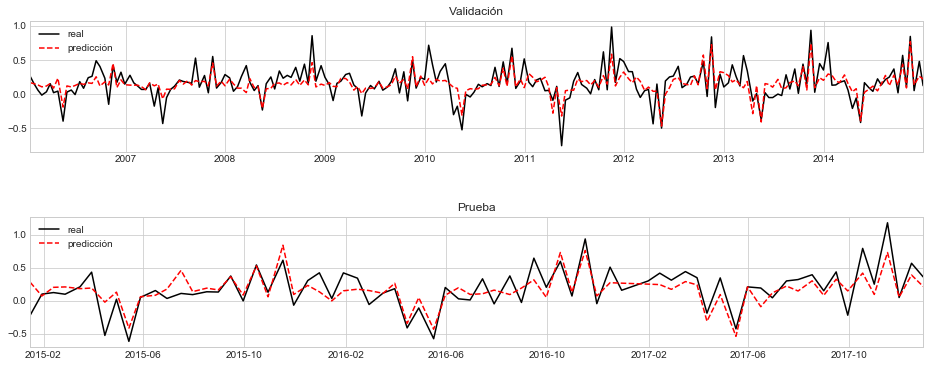

In [11]:
from sklearn.ensemble import RandomForestRegressor

rf = Pipeline([('selector', SelectorMacro(INPC_transf_rezago_1 =True,
                                          INPC_transf_rezago_2 =True,
                                          INPC_transf_rezago_3 =True,
                                          INPC_transf_rezago_4 =True,
                                          INPC_transf_rezago_10=True,
                                          INPC_transf_rezago_11=False,
                                          INPC_transf_rezago_12=True,
                                          INPC_transf_rezago_13=False,
                                          INPC_transf_rezago_14=False,
                                          INPC_transf_rezago_22=False,
                                          INPC_transf_rezago_23=True,
                                          INPC_transf_rezago_24=True,
                                          INPC_transf_rezago_25=True,
                                          INPC_transf_rezago_26=False,
                                          IGAE_transf_rezago_1     =True,
                                          IGAE_transf_rezago_2     =True,
                                          IPC_transf_rezago_1      =True,
                                          IPC_transf_rezago_2      =False,
                                          WTI_transf_rezago_1      =False,
                                          WTI_transf_rezago_2      =False,
                                          tiie_transf_rezago_1     =True,
                                          tiie_transf_rezago_2     =True,                                          
                                          usd_transf_rezago_1      =False,
                                          usd_transf_rezago_2      =True,
                                          yield_mex_transf_rezago_1=False, 
                                          yield_mex_transf_rezago_2=False,
                                          yield_usa_transf_rezago_1=False, 
                                          yield_usa_transf_rezago_2=False)),
               ('estimator', RandomForestRegressor(random_state=0, n_estimators=50,
                                                  min_samples_split=2, max_features=None,
                                                  max_depth=10))])

rf.fit(X_train, y_train)
evalua_modelo(rf)

# RandomForestRegressor train error: 0.0703
# RandomForestRegressor 5-fold CV error: 0.1567
# RandomForestRegressor test error: 0.1905

## Extra Trees

ExtraTreesRegressor train error: 0.0005
ExtraTreesRegressor 5-fold CV error: 0.1530
ExtraTreesRegressor test error: 0.1790


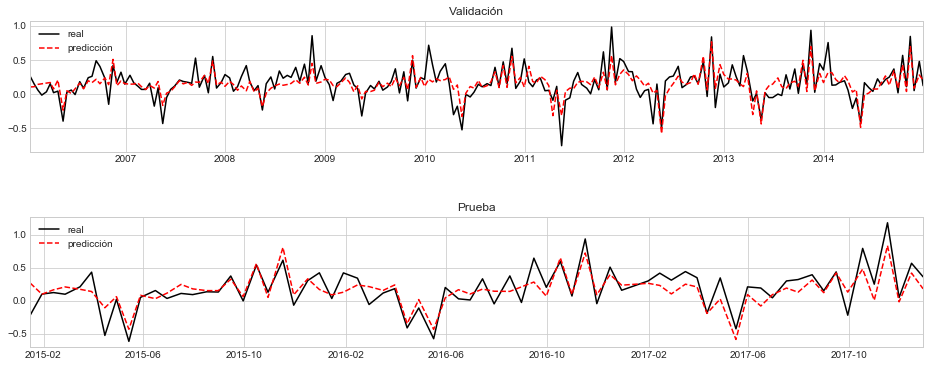

In [12]:
from sklearn.ensemble import ExtraTreesRegressor

et = Pipeline([('selector', SelectorMacro(INPC_transf_rezago_1 =True,
                                          INPC_transf_rezago_2 =True,
                                          INPC_transf_rezago_3 =False,
                                          INPC_transf_rezago_4 =True,
                                          INPC_transf_rezago_10=True,
                                          INPC_transf_rezago_11=True,
                                          INPC_transf_rezago_12=True,
                                          INPC_transf_rezago_13=True,
                                          INPC_transf_rezago_14=False,
                                          INPC_transf_rezago_22=False,
                                          INPC_transf_rezago_23=True,
                                          INPC_transf_rezago_24=True,
                                          INPC_transf_rezago_25=True,
                                          INPC_transf_rezago_26=False,
                                          IGAE_transf_rezago_1     =True,
                                          IGAE_transf_rezago_2     =True,
                                          IPC_transf_rezago_1      =False,
                                          IPC_transf_rezago_2      =False,
                                          WTI_transf_rezago_1      =False,
                                          WTI_transf_rezago_2      =False,
                                          tiie_transf_rezago_1     =True,
                                          tiie_transf_rezago_2     =False,                                          
                                          usd_transf_rezago_1      =False,
                                          usd_transf_rezago_2      =False,
                                          yield_mex_transf_rezago_1=False, 
                                          yield_mex_transf_rezago_2=True,
                                          yield_usa_transf_rezago_1=True, 
                                          yield_usa_transf_rezago_2=True)),
               ('estimator', ExtraTreesRegressor(random_state=0, n_estimators=50, 
                                                 min_samples_split=2, max_features=None, 
                                                 max_depth=30))])

et.fit(X_train, y_train)
evalua_modelo(et)
  
# ExtraTreesRegressor train error: 0.0005
# ExtraTreesRegressor 5-fold CV error: 0.1530
# ExtraTreesRegressor test error: 0.1790    

## Linear SVM

LinearSVR train error: 0.1471
LinearSVR 5-fold CV error: 0.1607
LinearSVR test error: 0.2172


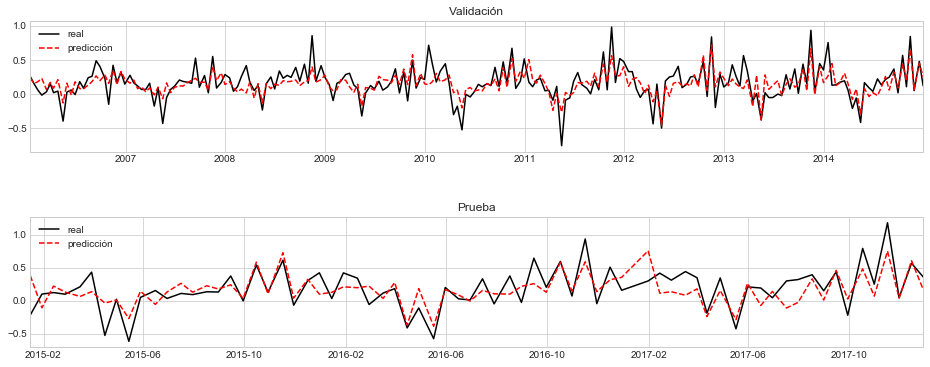

In [15]:
from sklearn.svm import LinearSVR

lsvm = Pipeline([('selector', SelectorMacro(INPC_transf_rezago_1 =True,
                                            INPC_transf_rezago_2 =False,
                                            INPC_transf_rezago_3 =False,
                                            INPC_transf_rezago_4 =False,
                                            INPC_transf_rezago_10=False,
                                            INPC_transf_rezago_11=False,
                                            INPC_transf_rezago_12=True,
                                            INPC_transf_rezago_13=False,
                                            INPC_transf_rezago_14=True,
                                            INPC_transf_rezago_22=True,
                                            INPC_transf_rezago_23=False,
                                            INPC_transf_rezago_24=True,
                                            INPC_transf_rezago_25=True,
                                            INPC_transf_rezago_26=True,
                                            IGAE_transf_rezago_1     =False,
                                            IGAE_transf_rezago_2     =False,
                                            IPC_transf_rezago_1      =False,
                                            IPC_transf_rezago_2      =False,
                                            WTI_transf_rezago_1      =True,
                                            WTI_transf_rezago_2      =False,
                                            tiie_transf_rezago_1     =False,
                                            tiie_transf_rezago_2     =False,                                          
                                            usd_transf_rezago_1      =False,
                                            usd_transf_rezago_2      =False,
                                            yield_mex_transf_rezago_1=True, 
                                            yield_mex_transf_rezago_2=True,
                                            yield_usa_transf_rezago_1=True, 
                                            yield_usa_transf_rezago_2=False)), 
                 ('scaler', MinMaxScaler()),   
                 ('estimator', LinearSVR(random_state=0, C=1.6331341609339447))])

lsvm.fit(X_train, y_train)
evalua_modelo(lsvm)

# LinearSVR train error: 0.1471
# LinearSVR 5-fold CV error: 0.1607
# LinearSVR test error: 0.2172

## Gradient Boosting

GradientBoostingRegressor train error: 0.0003
GradientBoostingRegressor 5-fold CV error: 0.1593
GradientBoostingRegressor test error: 0.1926


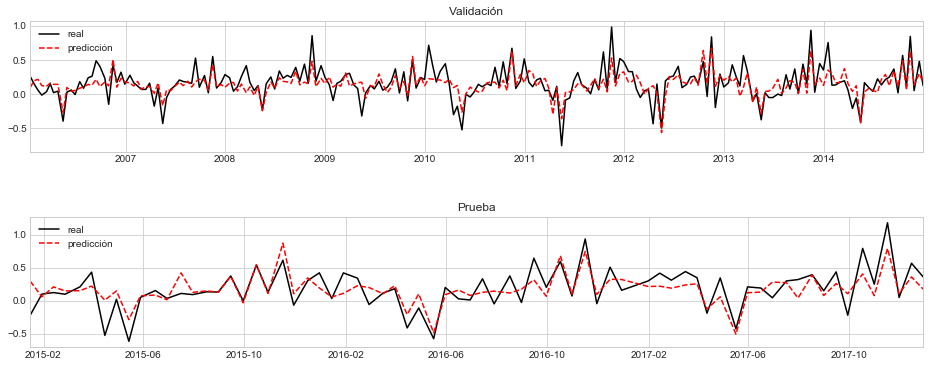

In [18]:
from sklearn.ensemble import GradientBoostingRegressor

gb = Pipeline([('selector', SelectorMacro(INPC_transf_rezago_1 =True,
                                          INPC_transf_rezago_2 =True,
                                          INPC_transf_rezago_3 =False,
                                          INPC_transf_rezago_4 =True,
                                          INPC_transf_rezago_10=False,
                                          INPC_transf_rezago_11=True,
                                          INPC_transf_rezago_12=True,
                                          INPC_transf_rezago_13=False,
                                          INPC_transf_rezago_14=False,
                                          INPC_transf_rezago_22=False,
                                          INPC_transf_rezago_23=True,
                                          INPC_transf_rezago_24=True,
                                          INPC_transf_rezago_25=True,
                                          INPC_transf_rezago_26=False,
                                          IGAE_transf_rezago_1     =False,
                                          IGAE_transf_rezago_2     =False,
                                          IPC_transf_rezago_1      =False,
                                          IPC_transf_rezago_2      =False,
                                          WTI_transf_rezago_1      =False,
                                          WTI_transf_rezago_2      =False,
                                          tiie_transf_rezago_1     =False,
                                          tiie_transf_rezago_2     =False,                                          
                                          usd_transf_rezago_1      =True,
                                          usd_transf_rezago_2      =False,
                                          yield_mex_transf_rezago_1=False, 
                                          yield_mex_transf_rezago_2=False,
                                          yield_usa_transf_rezago_1=False, 
                                          yield_usa_transf_rezago_2=False)),                                     
               ('estimator', GradientBoostingRegressor(random_state=0, n_estimators=100, 
                                                       max_features='sqrt', max_depth=10, 
                                                       learning_rate=0.1))])
gb.fit(X_train, y_train)
evalua_modelo(gb)

# GradientBoostingRegressor train error: 0.0003
# GradientBoostingRegressor 5-fold CV error: 0.1593
# GradientBoostingRegressor test error: 0.1926

## K Nearest Neighbors

KNeighborsRegressor train error: 0.1076
KNeighborsRegressor 5-fold CV error: 0.1507
KNeighborsRegressor test error: 0.1867


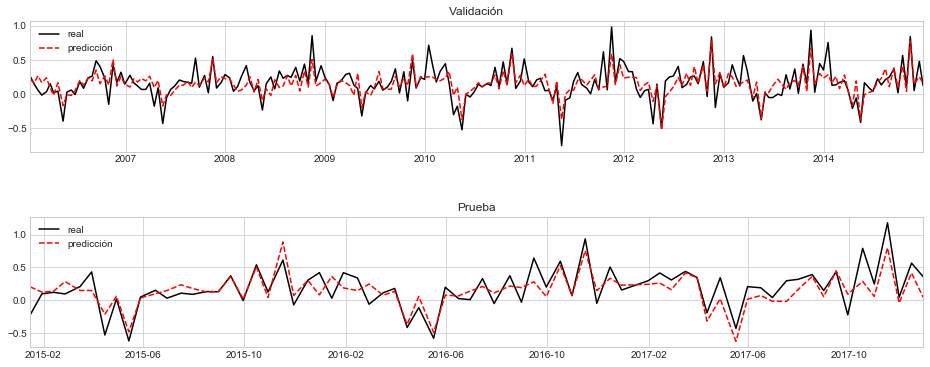

In [19]:
from sklearn.neighbors import KNeighborsRegressor

knn = Pipeline([('selector', SelectorMacro(INPC_transf_rezago_1 =True,
                                           INPC_transf_rezago_2 =True,
                                           INPC_transf_rezago_3 =False,
                                           INPC_transf_rezago_4 =True,
                                           INPC_transf_rezago_10=False,
                                           INPC_transf_rezago_11=False,
                                           INPC_transf_rezago_12=True,
                                           INPC_transf_rezago_13=False,
                                           INPC_transf_rezago_14=False,
                                           INPC_transf_rezago_22=False,
                                           INPC_transf_rezago_23=True,
                                           INPC_transf_rezago_24=True,
                                           INPC_transf_rezago_25=True,
                                           INPC_transf_rezago_26=False,
                                           IGAE_transf_rezago_1     =False,
                                           IGAE_transf_rezago_2     =True,
                                           IPC_transf_rezago_1      =False,
                                           IPC_transf_rezago_2      =False,
                                           WTI_transf_rezago_1      =False,
                                           WTI_transf_rezago_2      =False,
                                           tiie_transf_rezago_1     =True,
                                           tiie_transf_rezago_2     =False,                                          
                                           usd_transf_rezago_1      =False,
                                           usd_transf_rezago_2      =False,
                                           yield_mex_transf_rezago_1=False, 
                                           yield_mex_transf_rezago_2=False,
                                           yield_usa_transf_rezago_1=False, 
                                           yield_usa_transf_rezago_2=True)), 
                ('scaler', MinMaxScaler()),
                ('estimator', KNeighborsRegressor(n_neighbors=3))])

knn.fit(X_train, y_train)
evalua_modelo(knn)

# KNeighborsRegressor train error: 0.1076
# KNeighborsRegressor 5-fold CV error: 0.1507
# KNeighborsRegressor test error: 0.1867

In [20]:
modelos = [svm, rf, et, lsvm, gb, knn]

errs = pd.DataFrame(np.row_stack([evalua_modelo(mod, False) for mod in modelos]),
                    index=[type(mod.named_steps['estimator']).__name__ for mod in modelos],
                    columns=['train_rmse', 'cv_rmse', 'test_rmse'])

errs.sort_values('cv_rmse')

,train_rmse,cv_rmse,test_rmse
KNeighborsRegressor,0.107639,0.150666,0.186663
ExtraTreesRegressor,0.000491,0.153047,0.178976
SVR,0.137582,0.154612,0.208242
RandomForestRegressor,0.070293,0.156716,0.190513
GradientBoostingRegressor,0.000329,0.159270,0.192580
LinearSVR,0.147136,0.160659,0.217154


## Stacked

StackedRegressor train error: 0.0852
StackedRegressor 5-fold CV error: 0.1449
StackedRegressor test error: 0.1831


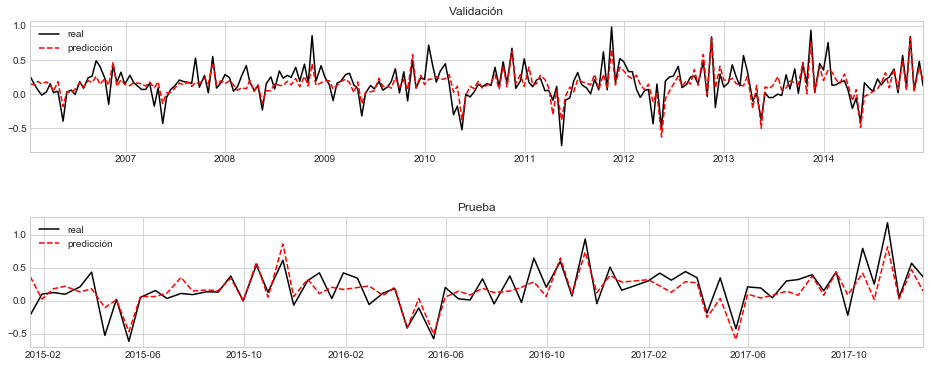

In [23]:
from sklearn.linear_model import Lasso

stacked = StackedRegressor(base_models=modelos, 
                           meta_model=Lasso(alpha=2.627626800693464e-05, positive=True, 
                                            random_state=0))
stacked.fit(X_train, y_train)
evalua_modelo(Pipeline([('estimator', stacked)]))

# StackedRegressor train error: 0.0852
# StackedRegressor 5-fold CV error: 0.1449
# StackedRegressor test error: 0.1831

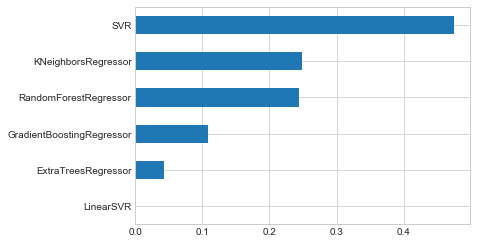

In [24]:
pd.DataFrame(stacked.meta_model_.coef_, 
             index=[type(mod.named_steps['estimator']).__name__ for mod in modelos],
             columns=['coef']).sort_values('coef').plot.barh(legend=False);